In [30]:
import sklearn.preprocessing
import torch
import delu
import delu.data
import math

# settings
device = torch.device('cuda')
delu.improve_reproducibility(base_seed=1024)

# wandb config
config = {
    "learning_rate": 0.0003,
    "epochs": 1000,
    "batch_size": 32,
    "dropout": 0.2,
    "train_split": 0.8,
    "weight_decay": 0.0,
    "patience": 20
}

In [31]:
import pandas as pd
import sklearn
import sklearn.model_selection
import sklearn.metrics
import torch
from torch.utils.data import Dataset

import delu
delu.improve_reproducibility(base_seed=1024)

class drdo_data(Dataset):
    def __init__(self, dataset, dep_variable, train_split, device,
                 all_pp: bool=False, no_pp: bool=False, target_pp: bool=False, feature_pp: bool=False,
                 type: int=1) -> None:
        self.train_split = train_split
        self.device = device
        self.dataset = dataset
        self.dep_variable = dep_variable
        self.df = pd.read_csv(dataset)
        self.X = {}
        self.y = {}

        y_all = self.df[dep_variable].astype('float32').to_numpy()
        X_all = self.df.drop(dep_variable, axis=1).astype('float32').to_numpy()

        if type == 1:
            print('type I processing')
            self.X['train'], self.X['test'], self.y['train'], self.y['test'] = sklearn.model_selection.train_test_split(
                X_all, y_all, train_size=train_split, random_state=1024)

            self.X['train'], self.X['val'], self.y['train'], self.y['val'] = sklearn.model_selection.train_test_split(
                self.X['train'], self.y['train'], train_size=train_split, random_state=1024)
        if type == 2:
            print('type II processing')
            self.X['train'] = X_all
            self.y['train'] = y_all
        
        if all_pp == True:
            print('processing: [features, targets]')
            preprocess = sklearn.preprocessing.QuantileTransformer()
            preprocess.fit(self.X['train'])
            self.X = {k: torch.tensor(preprocess.transform(v), device=device) for k, v in self.X.items()}
            self.y = {k: torch.tensor(v, device=device) for k, v in self.y.items()}
            self.y_mean = self.y['train'].mean().item()
            self.y_std = self.y['train'].std().item()
            self.y = {k: (v - self.y_mean) / self.y_std for k, v in self.y.items()}
        else:
            pass

        if no_pp == True:
            print('processing: []')
            self.X = {k: torch.tensor(v, device=device) for k, v in self.X.items()}
            self.y = {k: torch.tensor(v, device=device) for k, v in self.y.items()}
        else:
            pass

        if target_pp == True:
            print('processing: [targets]')
            self.X = {k: torch.tensor(v, device=device) for k, v in self.X.items()}
            self.y = {k: torch.tensor(v, device=device) for k, v in self.y.items()}
            self.y_mean = self.y['train'].mean().item()
            self.y_std = self.y['train'].std().item()
            self.y = {k: (v - self.y_mean) / self.y_std for k, v in self.y.items()}
        else:
            pass

        if feature_pp == True:
            print('processing: [features]')
            preprocess = sklearn.preprocessing.QuantileTransformer()
            preprocess.fit(self.X['train'])
            self.X = {k: torch.tensor(preprocess.transform(v), device=device) for k, v in self.X.items()}
            self.y = {k: torch.tensor(v, device=device) for k, v in self.y.items()}
        else:
            pass

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        return self.X['train'][index], self.y['train'][index]


In [32]:
df = pd.read_csv('../../data/SIDI_Full.csv')
df.head(3)

,LD,Velocity (km/s),a (degrees),$ (degrees),DI
0,1,0.25,90,75,0.00007
1,1,0.25,90,60,0.00580
2,1,0.25,90,45,0.01259


In [33]:
inp = drdo_data(
    dataset='../../data/phi/input_phi_0-75.csv',
    dep_variable='DI',
    train_split=0.8,
    device=device,
    feature_pp=True,
    type=2
)

filler = drdo_data(
    dataset='../../data/phi/filler_phi_0-75.csv',
    dep_variable='DI',
    train_split=0.8,
    device=device,
    feature_pp=True,
    type=2
)

full_data = drdo_data(
    dataset='../../data/SIDI_Full.csv',
    dep_variable='DI',
    train_split=0.8,
    device=device,
    feature_pp=True,
    type=1
)

type II processing
processing: [features]
type II processing
processing: [features]
type I processing
processing: [features]


/home/hackerman/miniconda3/envs/hvis/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (543). n_quantiles is set to n_samples.
  warnings.warn(


In [34]:
losses = {'input_phi': [], 'full_data': []}

In [35]:
# input_phi
import math
import rtdl

data = inp
eval_data = filler
model = rtdl.FTTransformer.make_default(
    n_num_features=data.X['train'].shape[1],
    cat_cardinalities=None,
    last_layer_query_idx=[-1],  # it makes the model faster and does NOT affect its output
    d_out=1,
)

model.to(device)
optimizer = (
    torch.optim.AdamW(model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay'])
)
loss_fn = torch.nn.MSELoss()

@torch.no_grad()
def evaluate(part):
    model.eval()
    pred = model(eval_data.X[part], x_cat=None).squeeze(1)
    target = eval_data.y[part]
    score = loss_fn(pred, target)
    return score

# Create a dataloader for batches of indices
batch_size = config['batch_size']
train_loader = delu.data.make_index_dataloader(len(data.X['train']), config['batch_size'])

# Create a progress tracker for early stopping
progress = delu.ProgressTracker(config['patience'])
print(f'Test score before training: {evaluate("train"):.4f}')

n_epochs = config['epochs']
for epoch in range(n_epochs):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = data.X['train'][batch_idx]
        y_batch = data.y['train'][batch_idx]
        loss = loss_fn(model(x_batch, x_cat=None).squeeze(1), y_batch)
        loss.backward()
        optimizer.step()

    # val_score = evaluate('val')
    test_score = evaluate('train')

    # valid_rmse = math.sqrt(val_score.cpu().numpy())
    test_rmse = math.sqrt(test_score.cpu().numpy())

    losses['input_phi'].append(test_rmse)

    print(f'Epoch {epoch:03d} | Test score: {test_score:.4f}', end='')
    progress.update((-1) * test_score)
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break


Test score before training: 0.2126
Epoch 000 | Test score: 0.0577 <<< BEST VALIDATION EPOCH
Epoch 001 | Test score: 0.0393 <<< BEST VALIDATION EPOCH
Epoch 002 | Test score: 0.0297 <<< BEST VALIDATION EPOCH
Epoch 003 | Test score: 0.0220 <<< BEST VALIDATION EPOCH
Epoch 004 | Test score: 0.0200 <<< BEST VALIDATION EPOCH
Epoch 005 | Test score: 0.0224
Epoch 006 | Test score: 0.0159 <<< BEST VALIDATION EPOCH
Epoch 007 | Test score: 0.0159 <<< BEST VALIDATION EPOCH
Epoch 008 | Test score: 0.0356
Epoch 009 | Test score: 0.0179
Epoch 010 | Test score: 0.0186
Epoch 011 | Test score: 0.0365
Epoch 012 | Test score: 0.0160
Epoch 013 | Test score: 0.0142 <<< BEST VALIDATION EPOCH
Epoch 014 | Test score: 0.0199
Epoch 015 | Test score: 0.0237
Epoch 016 | Test score: 0.0252
Epoch 017 | Test score: 0.0274
Epoch 018 | Test score: 0.0258
Epoch 019 | Test score: 0.0222
Epoch 020 | Test score: 0.0247
Epoch 021 | Test score: 0.0401
Epoch 022 | Test score: 0.0185
Epoch 023 | Test score: 0.0153
Epoch 024 | T

In [36]:
# full_data
import math
import rtdl

data = full_data
eval_data = full_data
model = rtdl.FTTransformer.make_default(
    n_num_features=data.X['train'].shape[1],
    cat_cardinalities=None,
    last_layer_query_idx=[-1],  # it makes the model faster and does NOT affect its output
    d_out=1,
)

model.to(device)
optimizer = (
    torch.optim.AdamW(model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay'])
)
loss_fn = torch.nn.MSELoss()

@torch.no_grad()
def evaluate(part):
    model.eval()
    pred = model(eval_data.X[part], x_cat=None).squeeze(1)
    target = eval_data.y[part]
    score = loss_fn(pred, target)
    return score

# Create a dataloader for batches of indices
batch_size = config['batch_size']
train_loader = delu.data.make_index_dataloader(len(data.X['train']), config['batch_size'])

# Create a progress tracker for early stopping
progress = delu.ProgressTracker(config['patience'])
print(f'Test score before training: {evaluate("test"):.4f}')

n_epochs = config['epochs']
for epoch in range(n_epochs):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = data.X['train'][batch_idx]
        y_batch = data.y['train'][batch_idx]
        loss = loss_fn(model(x_batch, x_cat=None).squeeze(1), y_batch)
        loss.backward()
        optimizer.step()

    # val_score = evaluate('val')
    test_score = evaluate('test')

    # valid_rmse = math.sqrt(val_score.cpu().numpy())
    test_rmse = math.sqrt(test_score.cpu().numpy())

    losses['full_data'].append(test_rmse)

    print(f'Epoch {epoch:03d} | Test score: {test_score:.4f}', end='')
    progress.update((-1) * test_score)
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break


Test score before training: 0.7096
Epoch 000 | Test score: 0.0199 <<< BEST VALIDATION EPOCH
Epoch 001 | Test score: 0.0082 <<< BEST VALIDATION EPOCH
Epoch 002 | Test score: 0.0034 <<< BEST VALIDATION EPOCH
Epoch 003 | Test score: 0.0049
Epoch 004 | Test score: 0.0047
Epoch 005 | Test score: 0.0037
Epoch 006 | Test score: 0.0020 <<< BEST VALIDATION EPOCH
Epoch 007 | Test score: 0.0024
Epoch 008 | Test score: 0.0020 <<< BEST VALIDATION EPOCH
Epoch 009 | Test score: 0.0032
Epoch 010 | Test score: 0.0013 <<< BEST VALIDATION EPOCH
Epoch 011 | Test score: 0.0025
Epoch 012 | Test score: 0.0015
Epoch 013 | Test score: 0.0014
Epoch 014 | Test score: 0.0013 <<< BEST VALIDATION EPOCH
Epoch 015 | Test score: 0.0018
Epoch 016 | Test score: 0.0015
Epoch 017 | Test score: 0.0021
Epoch 018 | Test score: 0.0014
Epoch 019 | Test score: 0.0010 <<< BEST VALIDATION EPOCH
Epoch 020 | Test score: 0.0010 <<< BEST VALIDATION EPOCH
Epoch 021 | Test score: 0.0012
Epoch 022 | Test score: 0.0019
Epoch 023 | Test s

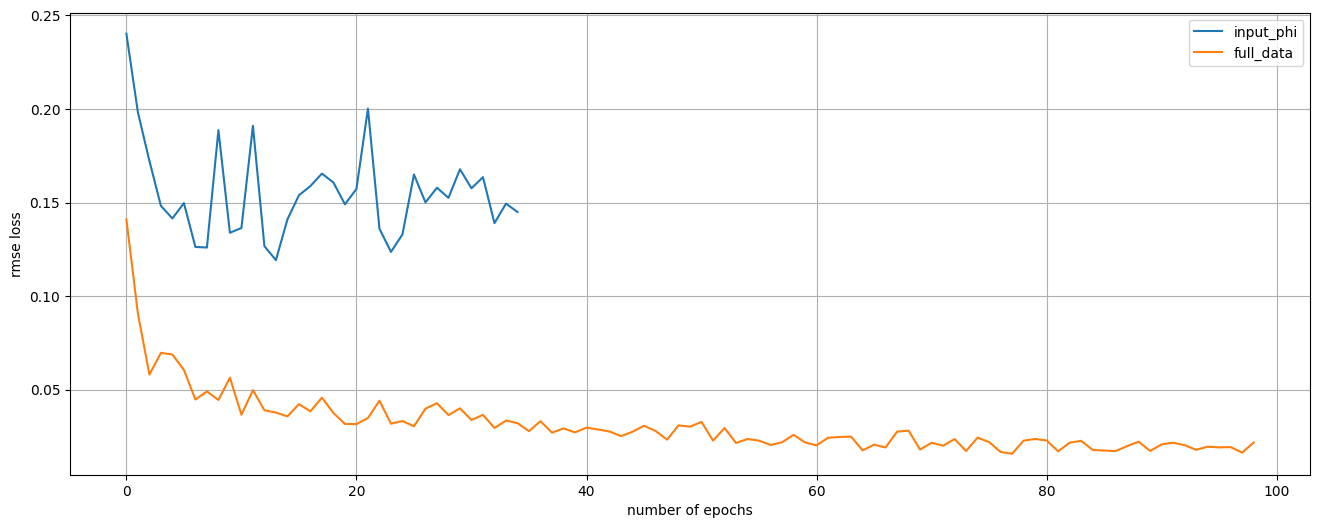

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.plot(losses['input_phi'], label='input_phi')
plt.plot(losses['full_data'], label='full_data')
plt.xlabel('number of epochs')
plt.ylabel('rmse loss')
plt.legend()
plt.grid()
plt.show()